# Categorize the unfair clauses

In [1]:
import pandas as pd
from numpy.random import RandomState
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import spacy as spacy
from nltk.corpus import stopwords 
from sklearn import preprocessing
from nltk.tokenize import word_tokenize 
from time import time
import string
import re
import sys

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.ext import Keras
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from focal_loss import BinaryFocalLoss

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from skmultilearn.problem_transform import LabelPowerset
from sklearn.utils import class_weight
import tensorflow.keras.backend as K
from sklearn.utils import resample

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import *
import itertools

Using TensorFlow backend.


In [5]:
class UnfairClauseCategorization(object):
    def __init__(self):
        self.df = pd.read_csv("../datasets/UnfairClauseClassifierDataset.csv")
        self.df = self.df.replace(-1, 0)
        
#         fig_size = plt.rcParams["figure.figsize"]
#         fig_size[0] = 10
#         fig_size[1] = 8
#         plt.rcParams["figure.figsize"] = fig_size
#         unfair_clause_labels.sum(axis=0).plot.bar()
#         print(unfair_clause_labels.sum(axis=0))
        
        self.NUM_WORDS = 5000
        self.EMBEDDING_DIM = 300
        self.tokenizer = Tokenizer(num_words=self.NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
        
    def clean_text(self):
        self.df['Text_Clean'] = self.df['Sentences'].apply(lambda x: self.remove_punct(x))
        tokens = [word_tokenize(sen) for sen in self.df.Text_Clean]
        lower_tokens = [self.lower_token(token) for token in tokens]
        filtered_words = [self.removeStopWords(sen) for sen in lower_tokens]
        self.df['Text_Final'] = [' '.join(sen) for sen in filtered_words]
        self.df['tokens'] = filtered_words 
        self.preprocess_text()
        
        self.df.Sentences = self.df.Text_Final
        
        self.df = self.df[['Sentences', 'Labels', 'Arbitration', 'Unilateral_Change', 'Content_Removal', 'Jurisdiction', 
                    'Choice_Of_Law', 'Limitation_Of_Liability', 'Unilateral_Termination', 'Contract_By_Using']]
        
    def upsample_and_split(self):
        df_fair = self.df[self.df.Labels==0]
        df_unfair = self.df[self.df.Labels==1]
        
        df_unfair_upsampled = resample(df_unfair,
                                      replace=True,
                                      n_samples=len(df_fair.index),
                                      random_state=43)
        self.df = pd.concat([df_fair, df_unfair_upsampled])
    
        self.df = self.df.loc[self.df['Labels'] == 1, ['Sentences', 'Arbitration', 'Unilateral_Change', 'Content_Removal', 'Jurisdiction', 
                    'Choice_Of_Law', 'Limitation_Of_Liability', 'Unilateral_Termination', 'Contract_By_Using']]

        unfair_clause_labels = self.df[['Arbitration', 'Unilateral_Change', 'Content_Removal', 'Jurisdiction', 
                                   'Choice_Of_Law', 'Limitation_Of_Liability', 'Unilateral_Termination', 'Contract_By_Using']]
        
        X = self.df.Sentences
        y = unfair_clause_labels.values
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=RandomState())
        
    def preprocess_text(self):
        nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
        brief_cleaning = (re.sub("[^A-Za-z]+", ' ', str(row)).lower() for row in self.df['Sentences'])
        t = time()
        txt = [self.cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
        print('Time taken to cleanup everything: {} mins'.format(round((time() - t)/60, 2)))
    
    def cleaning(self, doc):
        txt = [token.lemma_ for token in doc if not token.is_stop]
        if len(txt) > 2:
            return ' '.join(txt)
        
    def remove_punct(self, text):
        text_nopunct = ''
        text_nopunct = re.sub('['+string.punctuation+']', '', text)
        text_nopunct = re.sub(r'\s+', ' ', text_nopunct)
        text_nopunct = re.sub(r'\d+', '', text_nopunct)  #remove numbers
        text_nopunct = text_nopunct.strip()  #remove whitespaces
        return text_nopunct
    
    def lower_token(self, tokens): 
        return [w.lower() for w in tokens]   
    
    def removeStopWords(self, tokens): 
        stoplist = stopwords.words('english')
        return [word for word in tokens if word not in stoplist]
   
    def text_to_sequence(self):
        self.tokenizer.fit_on_texts(self.df.Sentences)
        sequences_train = self.tokenizer.texts_to_sequences(self.X_train)
        sequences_test = self.tokenizer.texts_to_sequences(self.X_test)
        
        vocab_size = len(self.tokenizer.word_index) + 1
        self.maxlen = max([len(s.split()) for s in self.df.Sentences])
        
        self.X_train = pad_sequences(sequences_train, padding='post', maxlen=self.maxlen)
        self.X_test = pad_sequences(sequences_test, padding='post', maxlen=self.maxlen)
            
        print('Shape of X train tensor:', self.X_train.shape)
        print('Shape of X test tensor:', self.X_test.shape)
        
        return vocab_size
    
    def word_to_vec(self, vocab_size):
        word_vectors = KeyedVectors.load_word2vec_format('../models/w2v_fair_model.bin', binary=True)
        embedding_matrix = np.zeros((vocab_size, self.EMBEDDING_DIM))

        for word, i in self.tokenizer.word_index.items():
            if i >= self.NUM_WORDS:
                continue
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), self.EMBEDDING_DIM)

        del(word_vectors)

        embedding_layer = Embedding(vocab_size, self.EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)
        return embedding_layer

    def create_model(self, embedding_layer):
        inputs = Input(shape=(self.maxlen,))
        embedding = embedding_layer(inputs)
        reshape = Reshape((self.maxlen, self.EMBEDDING_DIM, 1))(embedding)

        filter_sizes = [3, 3, 3, 3]
        num_filters = 32

        conv_0 = Conv2D(num_filters, (filter_sizes[0], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
        conv_1 = Conv2D(num_filters, (filter_sizes[1], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
        conv_2 = Conv2D(num_filters, (filter_sizes[2], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
        conv_3 = Conv2D(num_filters, (filter_sizes[2], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)

        maxpool_0 = MaxPooling2D((self.maxlen - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
        maxpool_1 = MaxPooling2D((self.maxlen - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
        maxpool_2 = MaxPooling2D((self.maxlen - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)
        maxpool_3 = MaxPooling2D((self.maxlen - filter_sizes[2] + 1, 1), strides=(1,1))(conv_3)

        merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
        flatten = Flatten()(merged_tensor)
        reshape = Reshape((3*num_filters,))(flatten)
        output = Dense(units=8, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(reshape)
        
        model = Model(inputs, output)
        adam = Adam(lr=1e-3)
        class_weights = self.calculate_class_weights()
#         class_weights = '{0:5, 1:1, 2:1, 3:3, 4:5, 5:1, 6:1, 7:1}'
        model.compile(loss=self.get_weighted_loss(class_weights), optimizer=adam, metrics=['acc'])
        return model
    
    def train_model(self, model):                     
        callback_checkpoint = ModelCheckpoint("categorize_model_weights.h5", monitor='val_loss', verbose=1, save_best_only=True)
        callbacks = [
            EarlyStopping(patience=5, monitor='val_loss'),
            callback_checkpoint
        ]          
        history = model.fit(self.X_train, self.y_train, batch_size=16, epochs=30, verbose=1, 
                            validation_split=0.3, callbacks=callbacks)

        print(model.summary())      
        return history, model
    
    def calculate_class_weights(self):
        number_dim = np.shape(self.y_test)[1]
        weights = np.empty([number_dim, 2])
        for i in range(number_dim):
            weights[i] = class_weight.compute_class_weight('balanced', [0., 1.], self.y_test[:, i])
        return weights    
    
    def get_weighted_loss(self, weights):
        def weighted_loss(y_true, y_pred):
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
        return weighted_loss
    
    def evaluate_model(self, history, model):
        loss, acc = model.evaluate(self.X_test, self.y_test, verbose = 1)
        print("Test Accuracy: %f" % (acc*100))

        y_pred = model.predict(self.X_test)
        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0
        
        print("ROC_AUC_SCORE: ",roc_auc_score(self.y_test, y_pred))

        target_names = ['Arbitration', 'Unilateral_Change', 'Content_Removal', 'Jurisdiction', 
                        'Choice_Of_Law', 'Limitation_Of_Liability', 'Unilateral_Termination', 'Contract_By_Using']

        print(classification_report(self.y_test, y_pred, target_names=target_names, zero_division='warn'))
        
        cnf_matrix = confusion_matrix(self.y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=[0, 1, 2, 3, 4, 5, 6, 7])
        np.set_printoptions(precision=2)
        plt.figure(figsize=(20,10))
        self.plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

        plt.figure(figsize=(20,10))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.show()
    
    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

    def predict(self, model):
        model.load_weights("categorize_model_weights.h5")
        predictions = model.predict(np.expand_dims(self.X_test[40], 0))
        print(self.tokenizer.sequences_to_texts([self.X_test[40]]))
        print(self.y_test[40])
        print(predictions)
        
    def getmaxlen(self): 
        return self.maxlen

In [6]:
def main():
    np.set_printoptions(threshold=np.inf)
    unfair_categorization = UnfairClauseCategorization()
    unfair_categorization.clean_text()
    unfair_categorization.upsample_and_split()
    vocab_size = unfair_categorization.text_to_sequence()
    embedding_layer = unfair_categorization.word_to_vec(vocab_size)
    model = unfair_categorization.create_model(embedding_layer)
    print(model.summary())
    history, model = unfair_categorization.train_model(model)
    unfair_categorization.evaluate_model(history, model)
    unfair_categorization.predict(model)
    with open('../models/UnfairClassifier.json', "w") as json_file:
        json_file.write(model.to_json())

Time taken to cleanup everything: 0.55 mins
Shape of X train tensor: (6705, 191)
Shape of X test tensor: (1677, 191)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 191)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 191, 300)     652200      input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 191, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 189, 1, 32)   28832       reshape_1

D:\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4693 samples, validate on 2012 samples
Epoch 1/30
4693/4693 [==============================] - 33s 7ms/step - loss: 0.5093 - acc: 0.7616 - val_loss: 0.4137 - val_acc: 0.8534

Epoch 00001: val_loss improved from inf to 0.41374, saving model to categorize_model_weights.h5
Epoch 2/30
4693/4693 [==============================] - 32s 7ms/step - loss: 0.3597 - acc: 0.8932 - val_loss: 0.3341 - val_acc: 0.9205

Epoch 00002: val_loss improved from 0.41374 to 0.33409, saving model to categorize_model_weights.h5
Epoch 3/30
4693/4693 [==============================] - 32s 7ms/step - loss: 0.2981 - acc: 0.9188 - val_loss: 0.2899 - val_acc: 0.9225

Epoch 00003: val_loss improved from 0.33409 to 0.28985, saving model to categorize_model_weights.h5
Epoch 4/30
4693/4693 [==============================] - 31s 7ms/step - loss: 0.2627 - acc: 0.9284 - val_loss: 0.2607 - val_acc: 0.9364

Epoch 00004: val_loss improved from 0.28985 to 0.26072, saving model to categorize_model_weights.h5
Epoch 5/30
4

1677/1677 [==============================] - 1s 679us/step
Test Accuracy: 94.812167
ROC_AUC_SCORE:  0.9908306010957065
                         precision    recall  f1-score   support

            Arbitration       0.93      1.00      0.96        62
      Unilateral_Change       0.96      0.98      0.97       311
        Content_Removal       0.91      0.98      0.94       199
           Jurisdiction       0.96      1.00      0.98       117
          Choice_Of_Law       0.98      0.98      0.98       122
Limitation_Of_Liability       0.97      0.99      0.98       487
 Unilateral_Termination       0.96      0.98      0.97       387
      Contract_By_Using       0.98      1.00      0.99       178

              micro avg       0.96      0.99      0.97      1863
              macro avg       0.95      0.99      0.97      1863
           weighted avg       0.96      0.99      0.97      1863
            samples avg       0.97      0.99      0.98      1863

Confusion matrix, without normali

D:\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


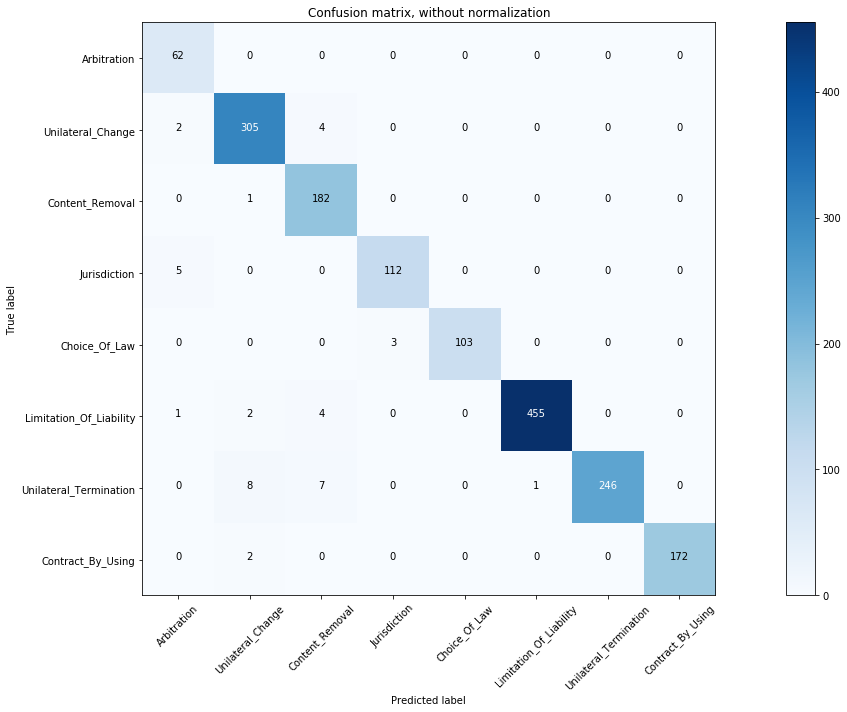

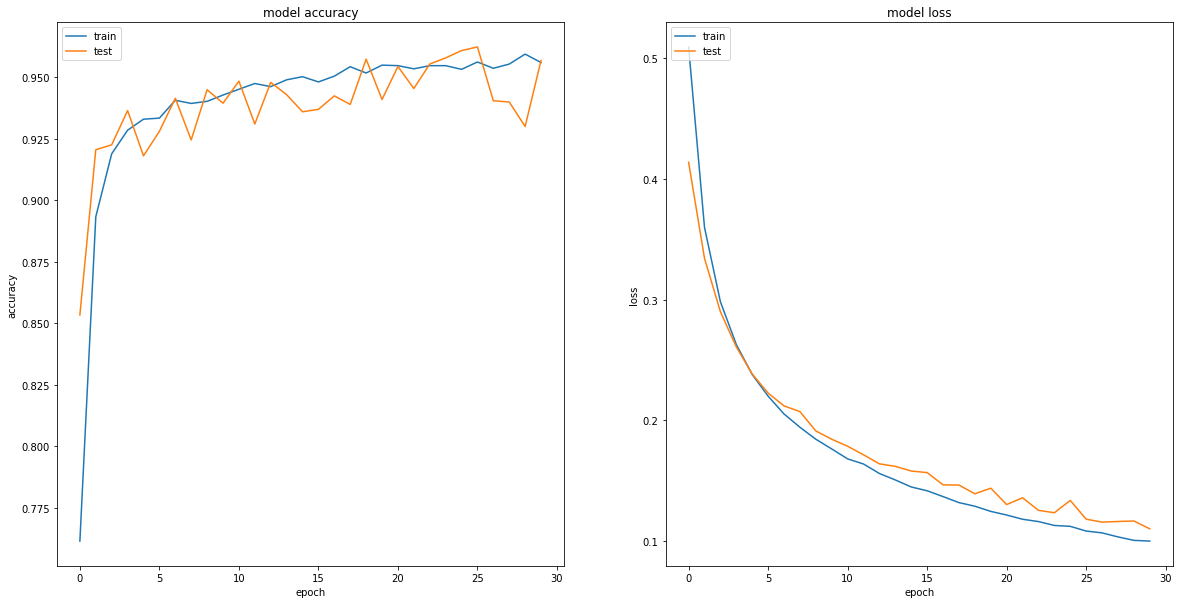

['niantic reserves right remove user content services time without notice reason']
[0 0 1 0 0 0 0 0]
[[0.09 0.07 1.   0.   0.01 0.04 0.12 0.02]]


In [7]:
if __name__=="__main__": main()

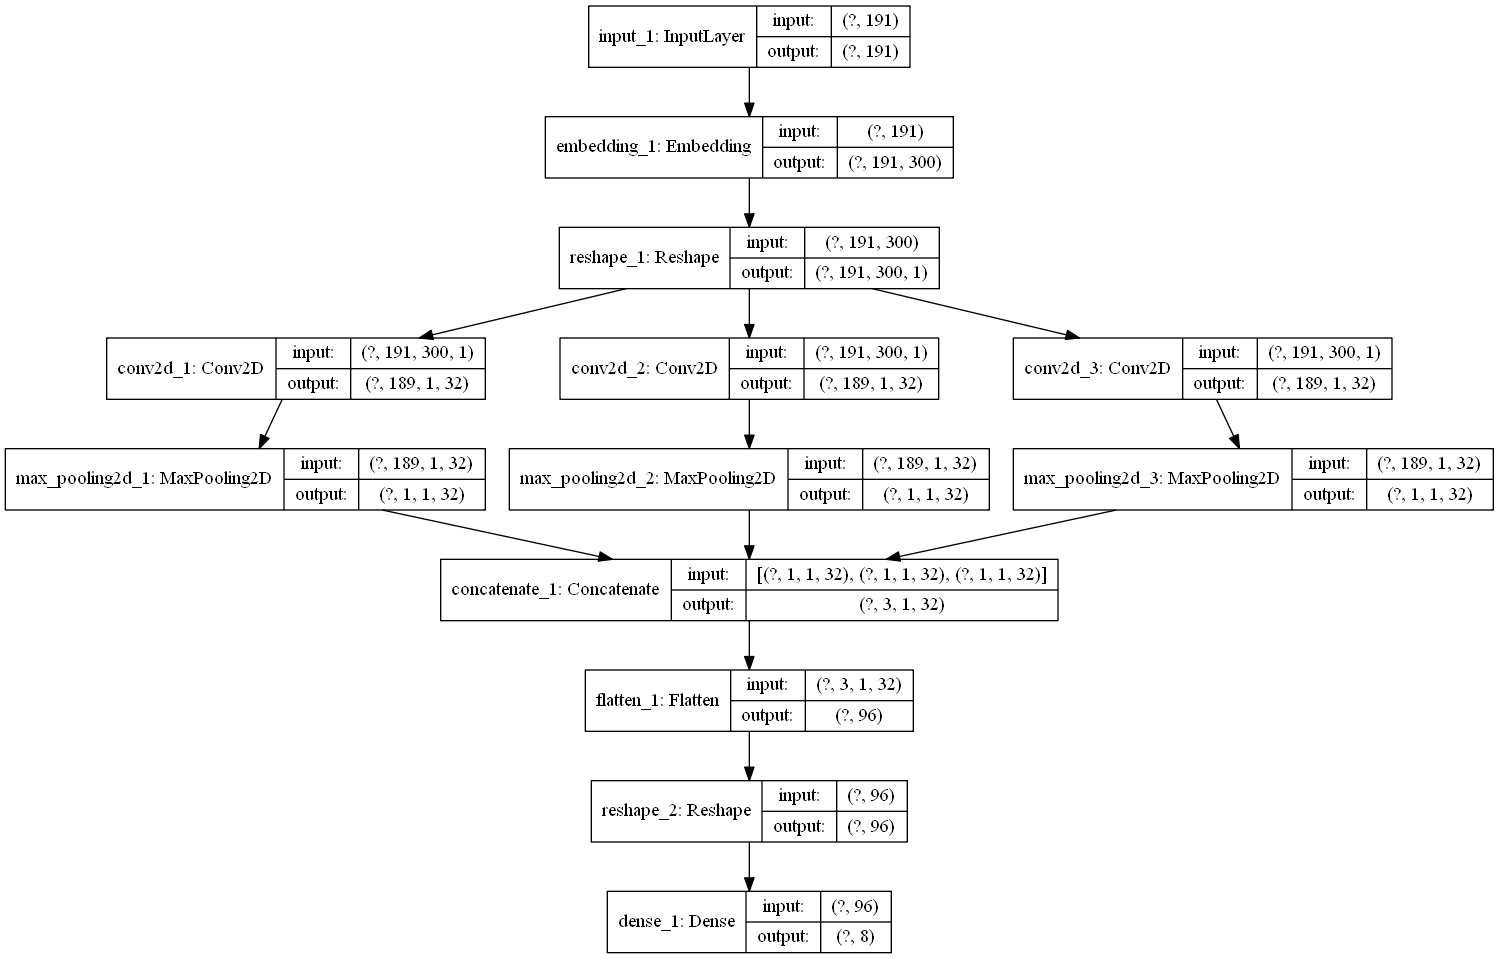

In [2]:
from keras.models import model_from_json
from tensorflow.keras.utils import plot_model
with open("../models/UnfairClassifier.json", "r") as f:
    data = f.read()
    model = model_from_json(data)
model.load_weights("categorize_model_weights.h5")
plot_model(model, to_file='unfair_model.png', show_shapes=True, show_layer_names=True)